In [14]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import datetime
import time
import matplotlib.pyplot as plt
from etf_tools import (
    EstimatorBucket,
    prepare_etf, ez_plot,
    evaluate_stacking
)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import shuffle as sk_shuffle

from sklearn.metrics import roc_auc_score, accuracy_score


plt.style.use('ggplot')
plt.ioff()


In [84]:
src_dir = '../data/raw/groupbycode/trainingset/'
code = '0050'
sample_file = os.path.join(src_dir, f'{code}.csv')

cont_feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'ema12', 'ema26', 'rsv', 'k', 'd', 'upward',
    'downward', 'rsi', 'open_gap', 'macd', 'osc', 'kbody'
]
cate_feature_cols = [f'month_{i + 1}' for i in range(12)] + [f'week_{i + 1}' for i in range(5)]

label_cols = ['y_1']


def feature_prep(df):
    months = pd.get_dummies(pd.Series(df.date.apply(lambda e: (e // 100) % 100)), prefix='month')
    weeks = pd.get_dummies(pd.Series(df.date.apply(lambda e: 1 + (e % 100) // 7)), prefix='week')
    return pd.concat([months, weeks, df[cont_feature_cols]], axis=1)


def label_prep(df):
    pass
    

def rnn_feature_trans(df):
    conts = df[cont_feature_cols]
    norms = ((conts - conts.mean()) / conts.std()).fillna(0)
    return pd.concat([df[cate_feature_cols], norms], axis=1)



In [85]:
%%time

X_all, y_all = prepare_etf(sample_file, cont_feature_cols + cate_feature_cols, label_cols, window=5,
                           etf_prep=lambda df: df.dropna(subset=label_cols),
                           feature_prep=feature_prep,
                           label_prep=lambda df: 1 * (df[label_cols].diff().fillna(0) > 0),
                           feature_trans=rnn_feature_trans)


CPU times: user 4.63 s, sys: 5.18 ms, total: 4.63 s
Wall time: 4.73 s


In [185]:
metrics = pd.read_csv('lstm/5day_classifier/evaluate/metrics.0050.201804.csv')
# metrics = metrics.set_index(metrics.epoch)

display(metrics.tail())
metrics.dtypes

,n_exp,epoch,val_auc,val_f1_top1,val_f1_top2,val_f1_top3,val_f1_th_top1,val_f1_th_top2,val_f1_th_top3,val_acc_top1,val_acc_top2,val_acc_top3,val_acc_th_top1,val_acc_th_top2,val_acc_th_top3
995,10,960,0.570390,0.56,0.56,0.56,0.01,0.32,0.31,0.622222,0.622222,0.622222,0.76,0.77,0.75
996,10,970,0.571429,0.56,0.56,0.56,0.01,0.32,0.31,0.622222,0.622222,0.622222,0.76,0.77,0.75
997,10,980,0.571429,0.56,0.56,0.56,0.01,0.32,0.31,0.622222,0.622222,0.622222,0.76,0.77,0.75
998,10,990,0.571429,0.56,0.56,0.56,0.01,0.31,0.30,0.622222,0.622222,0.622222,0.74,0.77,0.76
999,10,1000,0.571429,0.56,0.56,0.56,0.01,0.32,0.31,0.622222,0.622222,0.622222,0.76,0.77,0.75


n_exp                int64
epoch                int64
val_auc            float64
val_f1_top1        float64
val_f1_top2        float64
val_f1_top3        float64
val_f1_th_top1     float64
val_f1_th_top2     float64
val_f1_th_top3     float64
val_acc_top1       float64
val_acc_top2       float64
val_acc_top3       float64
val_acc_th_top1    float64
val_acc_th_top2    float64
val_acc_th_top3    float64
dtype: object

val_acc_top1                                                    \
n_exp           1         2         3         4         5         6    
epoch                                                                  
960       0.611111  0.611111  0.611111  0.611111  0.611111  0.622222   
970       0.611111  0.611111  0.611111  0.611111  0.611111  0.622222   
980       0.611111  0.611111  0.622222  0.611111  0.611111  0.622222   
990       0.611111  0.611111  0.611111  0.611111  0.611111  0.622222   
1000      0.611111  0.611111  0.611111  0.611111  0.611111  0.622222   

                                               
n_exp        7         8         9         10  
epoch                                          
960    0.622222  0.611111  0.611111  0.622222  
970    0.622222  0.611111  0.611111  0.622222  
980    0.622222  0.611111  0.611111  0.622222  
990    0.622222  0.622222  0.611111  0.622222  
1000   0.622222  0.622222  0.611111  0.622222

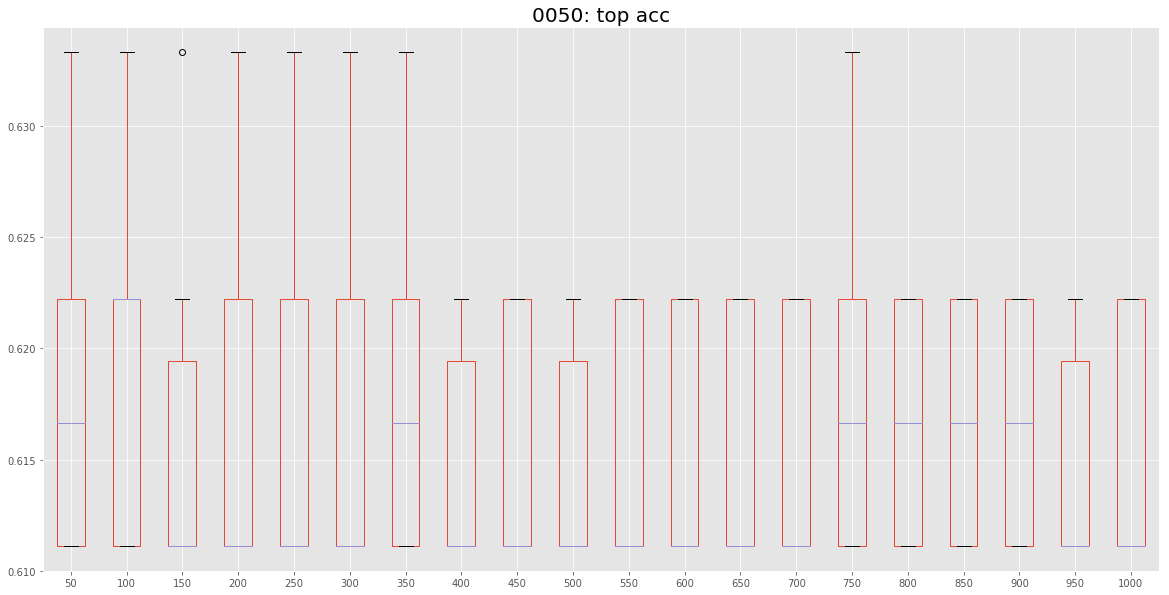

In [190]:
df = metrics[['val_acc_top1', 'n_exp', 'epoch']].pivot_table(columns=['n_exp'], index=['epoch'])
display(df.tail())
fig = ez_plot(df[df.index % 50 == 0].T, kind='box', title_prop={'label': '0050: top acc', 'size': 20})

# fig = ez_plot(metrics[metrics['n_exp'] == 5][['val_auc', 'val_acc_top1', 'val_f1_top1']],
#         title_prop={'label': '0050: experiment #5', 'size': 20},
#         legend_prop={'loc': 'lower left', 'fontsize': 24}) 

display(fig)
fig.savefig('acc.jpg')

val_f1_top1                                                              \
n_exp          1         2         3         4         5         6         7    
epoch                                                                           
4600     0.583333  0.521739  0.631579  0.600000  0.583333  0.583333  0.521739   
4700     0.521739  0.476190  0.571429  0.571429  0.583333  0.608696  0.560000   
4800     0.560000  0.476190  0.666667  0.600000  0.583333  0.608696  0.500000   
4900     0.560000  0.476190  0.705882  0.545455  0.583333  0.608696  0.560000   
5000     0.583333  0.476190  0.666667  0.545455  0.583333  0.608696  0.560000   

                                     
n_exp        8         9         10  
epoch                                
4600   0.545455  0.608696  0.608696  
4700   0.608696  0.625000  0.608696  
4800   0.545455  0.608696  0.636364  
4900   0.608696  0.588235  0.636364  
5000   0.608696  0.608696  0.608696

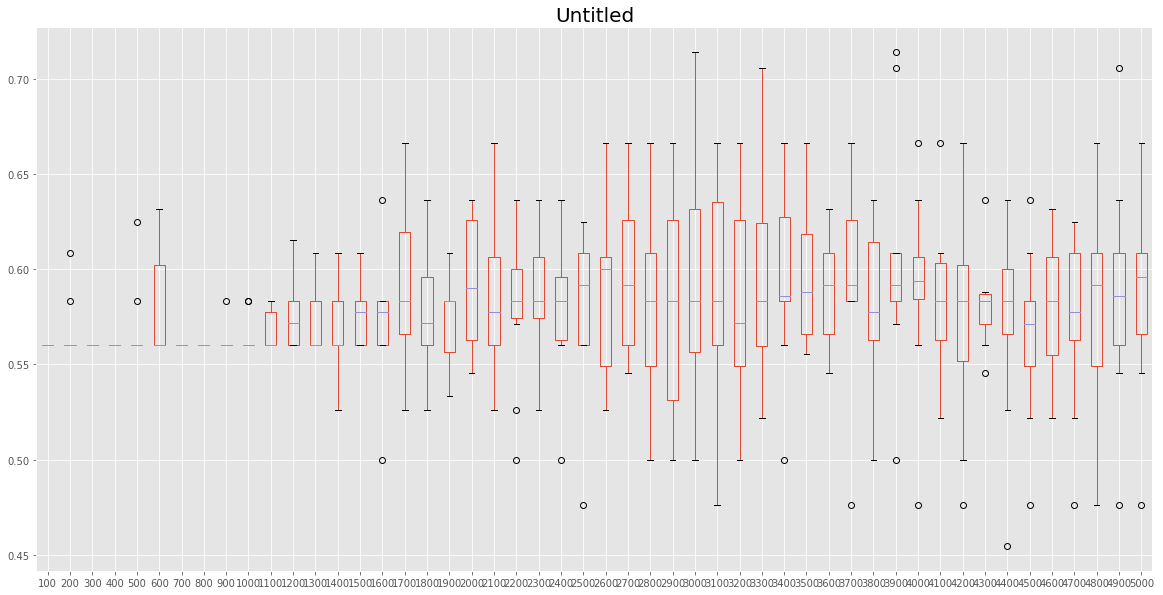

In [152]:
df = metrics[['val_f1_top1', 'n_exp', 'epoch']].pivot_table(columns=['n_exp'], index=['epoch'])
df = df[df.index % 100 == 0]
display(df.tail())
ez_plot(df.T, kind='box')

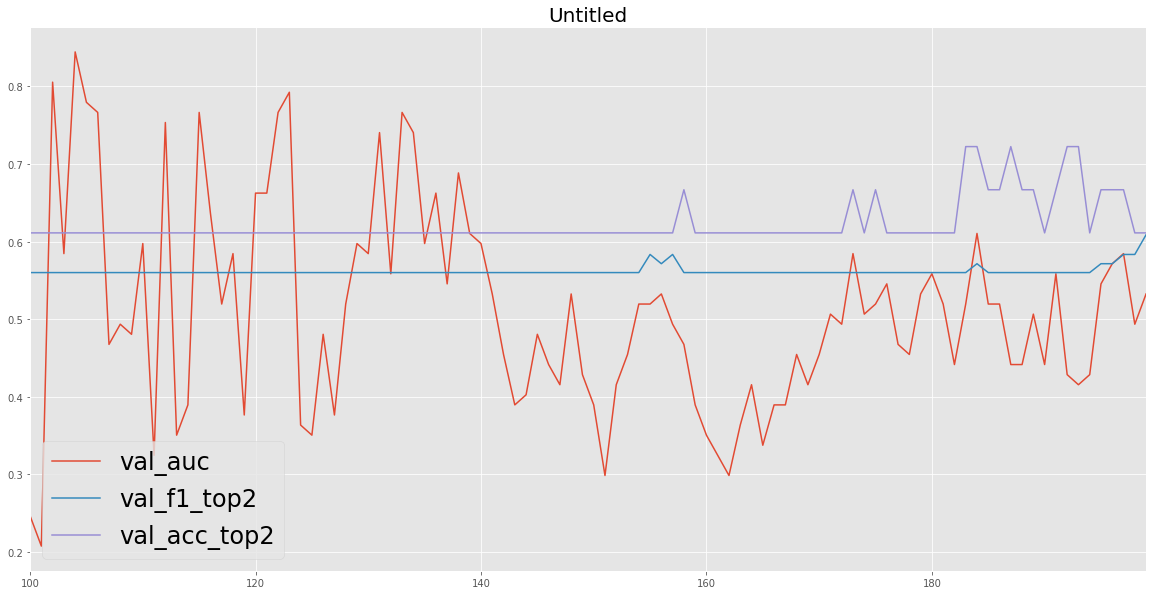

In [119]:
ez_plot(metrics[metrics['n_exp'] == 2][['val_auc', 'val_f1_top2', 'val_acc_top2']],
        legend_prop={'loc': 'lower left', 'fontsize': 24})

8395    0.49
8396    0.46
8397    0.48
8398    0.50
8399    0.43
dtype: float64

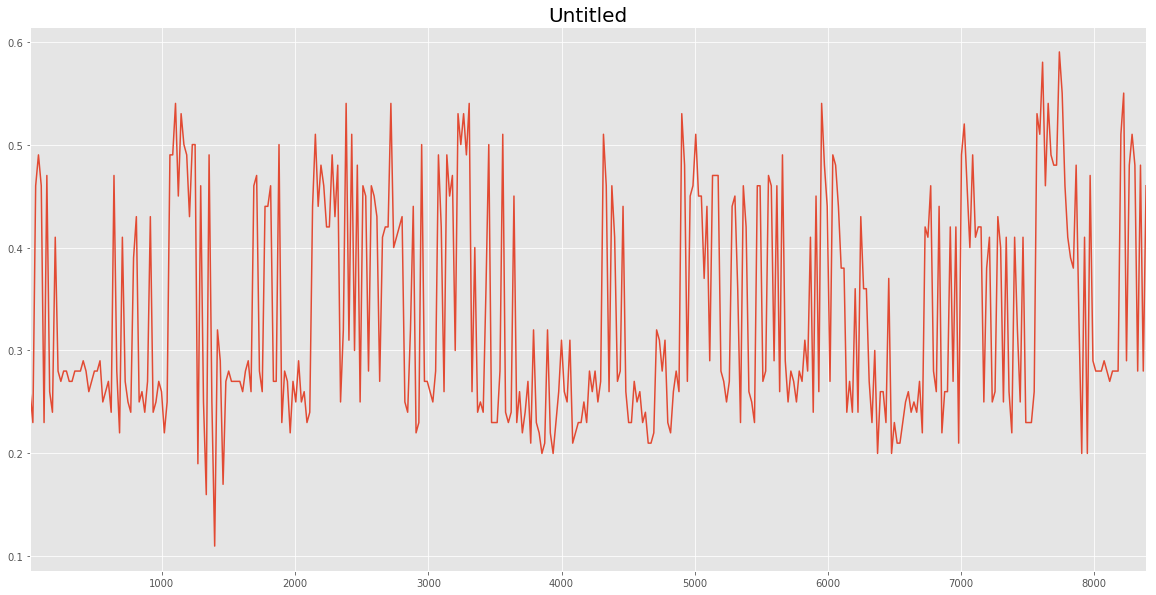

In [89]:
threshold_med = metrics[['val_th_top1', 'val_th_top2', 'val_th_top3']].median(axis=1)
display(threshold_med.tail())
ez_plot(threshold_med[metrics['epoch'] == 300])

In [90]:
year_month = [[f'{str(yr)}{str(mo).zfill(2)}' for yr, mo in zip(metrics.year.values, metrics.month.values)]]
alter_metrics = metrics.set_index(year_month).sort_values(['year', 'month', 'epoch', 'n_exp'])


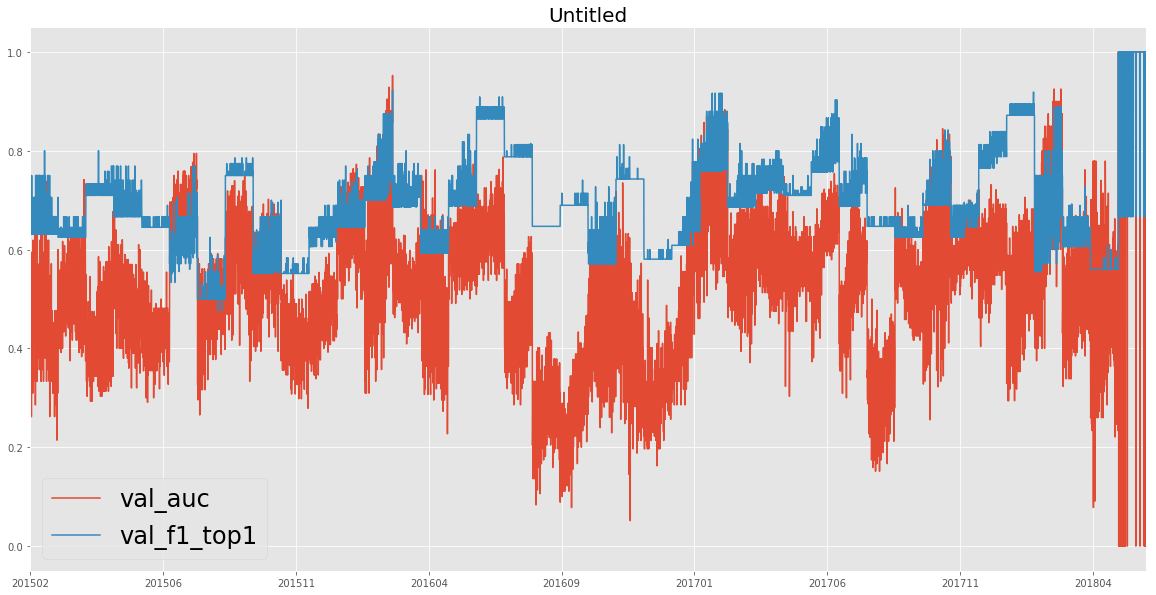

In [101]:

# display(alter_metrics[alter_metrics['epoch']].tail(n=20))
ez_plot(alter_metrics[['val_auc', 'val_f1_top1']],
        legend_prop={'loc': 'lower left', 'fontsize': 24})

In [10]:
metrics = [pd.read_csv(f'lstm/evaluate/archive.1/metrics.0050.2018-05-16.{i}.csv') for i in range(10)]
metrics[0].head()

,acc,batch,loss,size,val_acc,val_f1,val_auc
0,0.484375,0,0.693181,128,0.3,0.461538,0.476190
1,0.507812,0,0.691613,128,0.3,0.461538,0.523810
2,0.507812,0,0.694275,128,0.3,0.461538,0.619048
3,0.523438,0,0.691397,128,0.3,0.461538,0.666667
4,0.437500,0,0.695739,128,0.3,0.461538,0.285714


In [11]:
metrics[0].shape

(5000, 7)

# Acc Performance

In [18]:
val_acc = pd.concat([df['val_acc'] for df in metrics], axis=1)
df = val_acc[val_acc.index % 100 == 0]
print(df.shape)
display(df.shape)

(50, 10)


(50, 10)

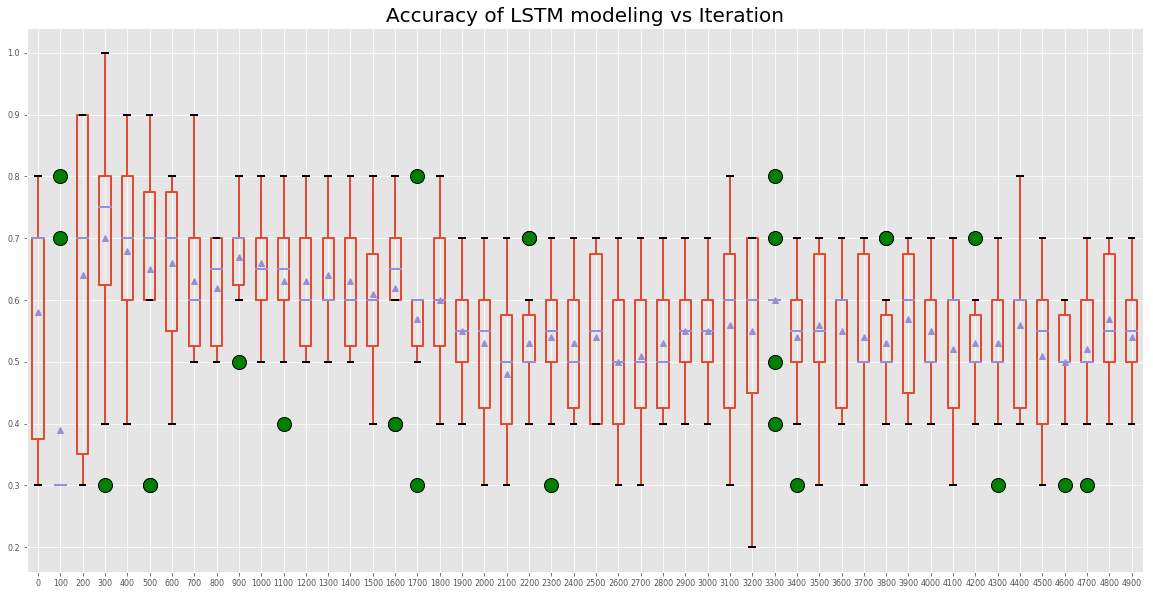

In [21]:
fig = ez_plot(df.T, fontsize=8, kind='box', showmeans=True, 
        title_prop={'label': 'Accuracy of LSTM modeling vs Iteration', 'size': 20},
        boxprops={'linewidth': 2, 'markerfacecolor': 'green'},
        whiskerprops={'linewidth': 2}, capprops={'linewidth': 2},
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        flierprops=dict(marker='o', markerfacecolor='green', markersize=14, linestyle='none'))

display(fig)

# AUC Performance

In [34]:
val_auc = pd.concat([df['val_auc'] for df in metrics], axis=1)
df = val_auc[(val_auc.index < 400) & (val_auc.index % 10 == 0)]
print(df.shape)
display(df.shape)

(40, 10)


(40, 10)

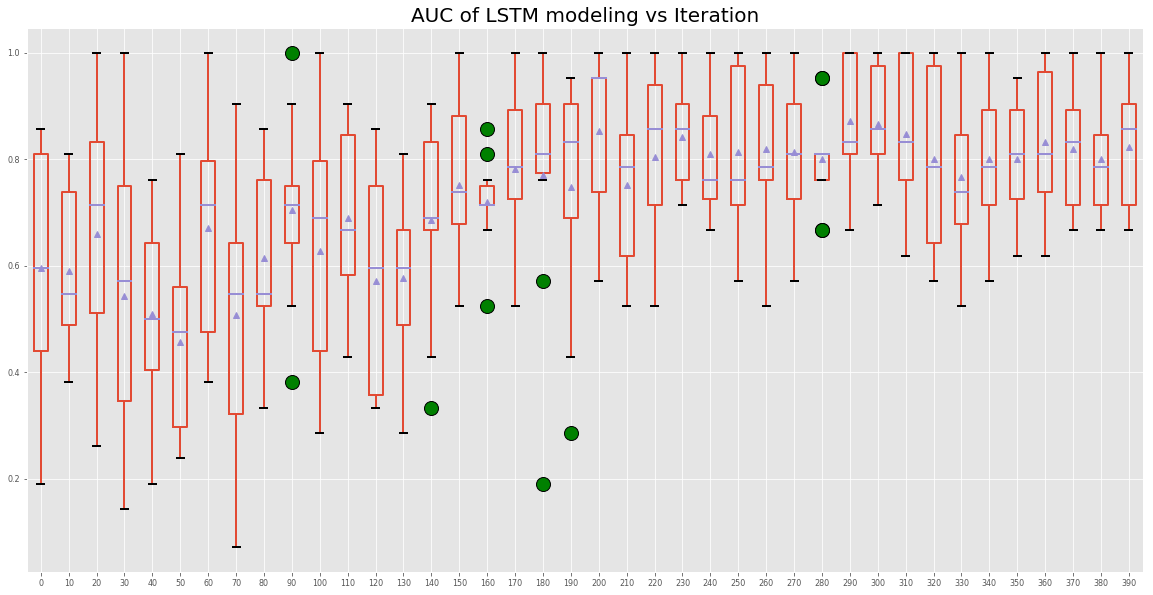

In [35]:
fig = ez_plot(df.T, fontsize=8, kind='box', showmeans=True, 
        title_prop={'label': 'AUC of LSTM modeling vs Iteration', 'size': 20},
        boxprops={'linewidth': 2, 'markerfacecolor': 'green'},
        whiskerprops={'linewidth': 2}, capprops={'linewidth': 2},
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        flierprops=dict(marker='o', markerfacecolor='green', markersize=14, linestyle='none'))

display(fig)

# F1-Score Performance

In [27]:
val_f1 = pd.concat([df['val_f1'] for df in metrics], axis=1)
df = val_f1[val_f1.index % 100 == 0]
print(df.shape)
display(df.shape)

(50, 10)


(50, 10)

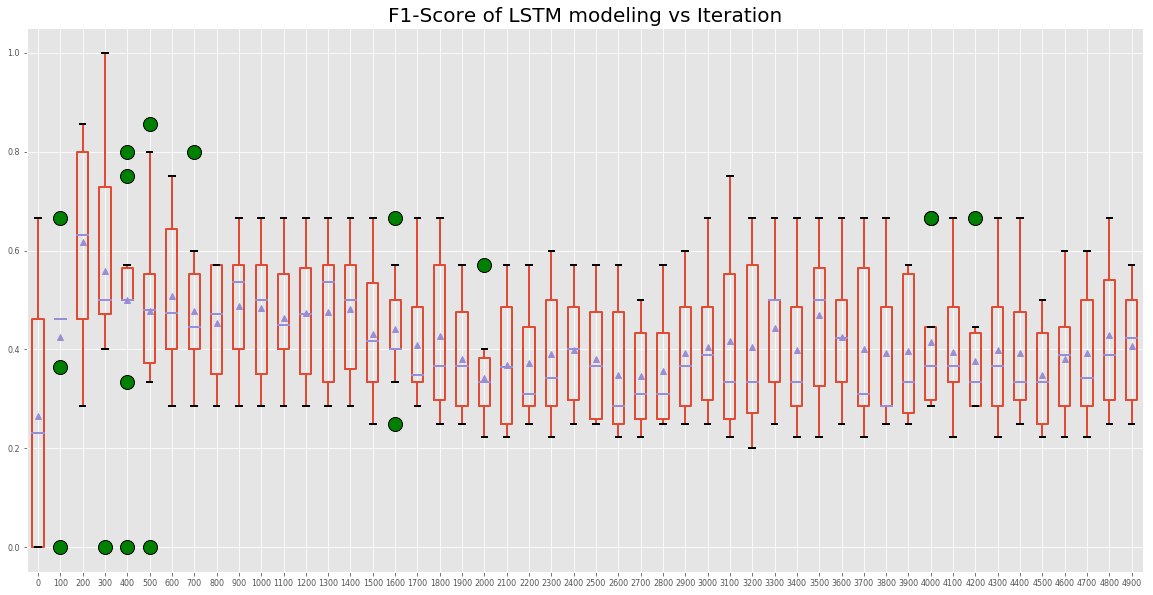

In [28]:
fig = ez_plot(df.T, fontsize=8, kind='box', showmeans=True, 
        title_prop={'label': 'F1-Score of LSTM modeling vs Iteration', 'size': 20},
        boxprops={'linewidth': 2, 'markerfacecolor': 'green'},
        whiskerprops={'linewidth': 2}, capprops={'linewidth': 2},
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        flierprops=dict(marker='o', markerfacecolor='green', markersize=14, linestyle='none'))

display(fig)

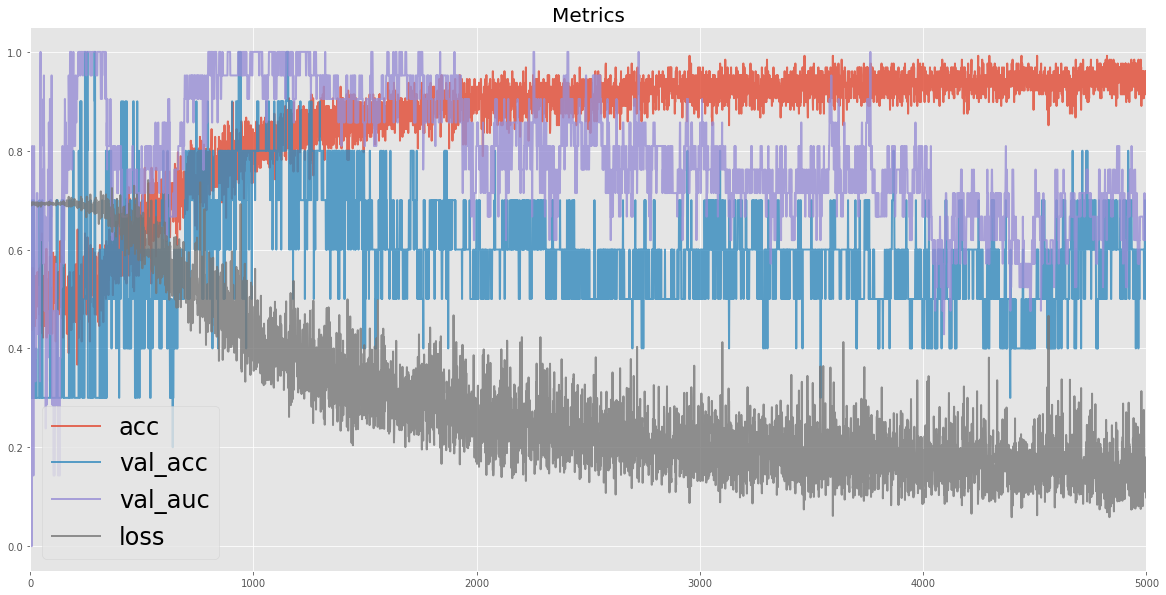

In [155]:
ez_plot(metrics[['acc', 'val_acc', 'val_auc', 'loss']],
        linewidth=2, alpha=0.8,
        title_prop=dict(label='Metrics', size=20),
        legend_prop=dict(loc='lower left', fontsize=24))